# Fifth National Climate Assessment: 
#### Figure 21.4: Temperature Anomalies and Marine Heat Waves
#### Data Analysis Documentation
Adam A. Kemberling - Gulf of Maine Research Institute


# About this Notebook

This notebook details the data acquisition steps for acquiring daily SST records from NOAA's Physical Science Laboratory and the THREDDS catalog. Following data acquisition, data is transformed from a gridded Netcdf format to an area-average for the Gulf of Maine. This notebook details all tranformation steps starting from global coverage Netcdfs to a timeseries of SST values for the Gulf of Maine Ecological Production Unit (EPU).

# Data Acquisition:

NOAA's Physical Science Laboratory has NOAA OISSTv2 (Daily Satellite SST Data Source) available as yearly Netcdf Files. This is the most convenient form I've found it, as the entire period needed for this figure of 1982-2021 is too big to save as a single .nc file.

Link to the data resource from NOAA PSL:   
https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html

An example annual file in the THREDDS catalog:   
https://psl.noaa.gov/thredds/catalog/Datasets/noaa.oisst.v2.highres/catalog.html?dataset=Datasets/noaa.oisst.v2.highres/sst.day.mean.1982.nc

The catalog where all years can be found for different variables:   
https://psl.noaa.gov/thredds/catalog/Datasets/noaa.oisst.v2.highres/catalog.html

*NOTE:* The documentation that follows requires an annual file for all years 1982-2021 be downloaded. These files will then be loaded and processed using `xarray` in the following sections.

## Set Workspace:

Need to load the following libraries and make sure we are working in the directory where both the SST files are located as well as the spatial boundary being used as a mask.

In [13]:
# Libraries
import os
import dask
import xarray as xr
import datetime
import geopandas as gpd
import regionmask
import numpy as np


#### 1. Set workspace
# This should be the location where the annual files are stored:
# Our company uses Box for cloud storage in this example
box_root = "/Users/akemberling/Library/CloudStorage/Box-Box/"
oisst_location  = f"{box_root}RES_Data/OISST/oisst_mainstays/annual_observations/"
base_fname      = "sst.day.mean."
file_ending     = ".v2.nc"

# Print where we are working
print(f"Example File Located at: {oisst_location}{base_fname}1982{file_ending}")

Example File Located at: /Users/akemberling/Library/CloudStorage/Box-Box/RES_Data/OISST/oisst_mainstays/annual_observations/sst.day.mean.1982.v2.nc


## Load the OISST Data as 1 Dataset

xarray lets use load all the annual files as one big data cube that we can process directly as if it were one big file. This saves so much headache.

In [5]:
#### 2. Select Years to Process# Set start and end years for the update
start_yr = 1982
end_yr   = 2021

# Load the annual files for oisst
fpaths = []
for yr in range(start_yr, end_yr + 1):
    fpaths.append(f'{oisst_location}{base_fname}{yr}{file_ending}')
    
# Lazy-load using xr.open_mfdataset
grid_obj = xr.open_mfdataset(fpaths, combine = "by_coords", parallel = True)
grid_obj

<xarray.Dataset>
Dimensions:  (time: 14610, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2021-12-31
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(365, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:35:47 2017: ncatted -O -a References,global...
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature

## Load the Shapefile Mask

For this figure we used the spatial footprint of the Gulf of Maine EPU. This area's geographic footprint is available through NOAA's Northeast Fisheries Science Center. I have downloaded it for our use using their R package "ecodata". That package installs with the shapefile, making it a consistent access point.

<AxesSubplot:>

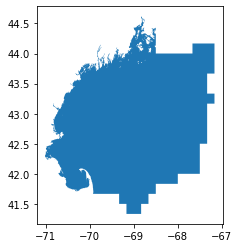

In [8]:
# Load the polygon to crop with

# Mask Path
mask_path = f"{box_root}RES_Data/Shapefiles/EPU/individual_epus/GOM.geojson"
mask_shape = gpd.read_file(mask_path)
mask_shape.plot()

### Function to Calculate a Masked Timeseries

Because these steps go together frequently: mask -> crop -> average, I've combined the flow into one function. Before we can use it we need to also add another function for weighting the cell areas properly.

To account for any distortion in cell area caused by the projection to a rectangular grid, cells are weighted based on latitude when calculating averages over a large area.

In [9]:
# Define a function to weight cell area when doing a mean across lat/lon space

def area_weighted_means(grid_obj, var_name = "sst"):
    """
    Run an area-weighted average using an xarray dataset, the cell weights, and the variable of interest.
    
    Area of the cells is based on latitude and assumes a rectangular grid in lat/lon converting to km
    
    Args:
        grid_obj     : xr.Dataset to calculate average of
        var_name     : data variable
    """
    
    # Pull an array of the variable of interest
    array_var = getattr(grid_obj, var_name)
    
    #  Manual Weighting Code From Julius Busecke in Ocean Hack Week 2020
    #  delta_lon = np.cos(array_var.lat * np.pi / 180) * 111e3
    #  delta_lat = xr.ones_like(array_var.lon) * 111e3
    #  cell_areas = delta_lon * delta_lat
    
    # From Source: xarray docs
    # http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html
    cell_areas = np.cos(np.deg2rad(array_var.lat))
    cell_areas.name = "weights"
    
    # weight the array with the areas
    grid_weighted = array_var.weighted(cell_areas)
    
    # Get the mean
    print("Processing Area-Weighted Means")
    weighted_vals = grid_weighted.mean(("lat", "lon"))
    weighted_vals = weighted_vals.to_dataset(name = f"area_wtd_{var_name}")

    
    return weighted_vals

In [15]:
def calc_ts_mask(grid_obj, shp_obj, shp_name, var_name = "sst"):
  """
  Return a timeseries using data that falls within shapefile. 
  
  Standard deviation
  not included so that this function can be used for any period of time.
  
  Args:
    grid_obj       : xr.Dataset of the desired input data to mask
    shp_obj        : shapefile polygon to use as a mask
    shp_name (str) : String to use as name when making mask
    var_name (str) : Optional string identifying the variable to use
  """

  #### 1. Make the mask
  area_mask = regionmask.Regions(shp_obj.geometry, name = shp_name)

  #### 2. Mask the array with gom_mask to get nan test
  mask = area_mask.mask(grid_obj, lon_name = "lon", lat_name = "lat")

  #### 3. Extract data that falls within the mask
  masked_ds = grid_obj.where(~np.isnan(mask))

  
  #### 4. Calculate timeseries mean

  # Get the timeseries mean of the desired variable
  
  # a. Area-weighted Means
  masked_ts = area_weighted_means(masked_ds, var_name)
    
  # b. Not area-weighted
  masked_ts[var_name] = getattr(masked_ds, var_name).mean(dim = ("lat", "lon"))
    
   
  #### 5. Change time index rownames to a column 

  # Convert to Timeseries Dataframe
  masked_ts_df = masked_ts.to_dataframe()

  # Reset the index, rename variables
  masked_ts_df = masked_ts_df.reset_index()[["time", f"area_wtd_{var_name}", var_name]]
  
  # Return the table as output
  return masked_ts_df

## Crop the SST Data to Within the Gulf of Maine, Create Timeseries

This step just takes any cells outside the boundaries defined by our shapefile and removes that information from any future steps. We then average the SST values that remain together at each daily time step to create a timeseries that can be saved as a .csv file.

In [16]:

# Get masked timeseries for the Gulf of Maine
gom_masked_ts = calc_ts_mask(
    grid_obj = grid_obj, 
    shp_obj = mask_shape, 
    shp_name = "Gulf of Maine EPU",
    var_name = "sst")

/Users/akemberling/opt/anaconda3/envs/py3oisst/lib/python3.8/site-packages/regionmask/core/regions.py:410: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in poly:


Processing Area-Weighted Means


In [17]:
# Check it out
gom_masked_ts.head()

,time,area_wtd_sst,sst
0,1982-01-01,7.454046,7.450916
1,1982-01-02,7.285585,7.282166
2,1982-01-03,7.254751,7.252334
3,1982-01-04,7.239621,7.237584
4,1982-01-05,7.160709,7.158834


In [ ]:
# Save it somewhere so we can make a plot in R
save_path = "somewhere_on_my_computer/my_sst_file.csv"
gom_masked_ts.to_csv(save_path, index = False)